## Triplet Loss

Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.


**Что нужно учесть при реализации Triplet Loss**:
- при обучении мы обычно хотим следить за ходом обучения модели, считая какую-то метрику качества. Тут у нас больше нет классификационного слоя, так что accuracy мы считать не можем. Нужно придумать, как в случае Triplet Loss считать метрику качества на вализации в течение обучения. Подумайте, как можно это сделать?
- скорее всего, чтобы обучить сеть на Triplet Loss, придется написать кастомный Dalaset/Dataloader, который будет возвращать тройки элементов (anchor, positive, negative).
- не забудьте нормализовать эмбеддинги перед подсчетом лосса! Это можно сделать руками, а можно, например, добавить в конец сети batchnorm без обучаемых параметров.

**Доп литература по Triplet Loss**:

- Идея TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss
- Хорошая статья про batch mining techniques для выбора positive и negative элементов: https://omoindrot.github.io/triplet-loss#triplet-mining


## Импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import numpy as np
import pandas as pd

from PIL import Image
import os
import random
import gc

from tqdm import tqdm
from matplotlib import pyplot as plt
import json
import pickle
import time

In [2]:
os.getcwd()

'/home/alex/Downloads/DLS-1_autumn 2025-FR_project/to_GitHub/notebooks'

In [3]:
import sys
sys.path.append('..')  # этот ноутбук должен находиться в папке notebooks

from src.models import FRModel, FRModel_ArcFace

In [32]:
# устанавливаем ядра рандомов
RANDOM_SEED = 4242
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {DEVICE}")




dir_dataset = '../data_CelebA_mini'  # папка для уменьшенного датасета
dir_aligned = f'{dir_dataset}/data_aligned'  # папка для выровненных изображений уменьшенного датасета

base_dir = f'{dir_dataset}/data_fr' # папка для формирования датасета для распознавания лиц (физическое разделение изображений)
ident_dir = f'{dir_dataset}/data_IRM' # папка для реализации Identification Rate Metric
dir_metadata_fr = f'{dir_dataset}/metadata_fr' # папка для метаданных для распознавания лиц


# файл метаданных
metadata_aligned = f'{dir_dataset}/list_attr_celeba_mini.csv'


# папки для обучения
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'
# папки для identification rate
query_dir = f'{ident_dir}/query'
distractors_dir = f'{ident_dir}/distractors'


dir_checkpoints = 'checkpoints' # папка для сохранения чекпоинтов

BATCH_SIZE = 64
EMBEDDING_SIZE = 512

Используемое устройство: cuda


## Triplet loss

In [ ]:
class TripletLoss(nn.Module):
    """Triplet Loss для обучения эмбеддингов лиц"""
    def __init__(self, margin=0.2):
        super().__init__()
        self.margin = margin
    

    def forward(self, anchor, positive, negative):
        """
        Вычисляет triplet loss
        
        Args:
            anchor: эмбеддинги anchor изображений [batch_size, embedding_dim]
            positive: эмбеддинги positive изображений [batch_size, embedding_dim] 
            negative: эмбеддинги negative изображений [batch_size, embedding_dim]
            
        Returns:
            loss: scalar значение лосса
        """
        # нормализация эмбеддингов для стабильности
        anchor = F.normalize(anchor, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)
        
        # косинусное сходство
        cos_ap = F.cosine_similarity(anchor, positive, dim=1)
        cos_an = F.cosine_similarity(anchor, negative, dim=1)
        
        # косинусное расстояние = 1 - косинусное сходство
        d_ap = 1 - cos_ap
        d_an = 1 - cos_an
        
        # Triplet loss: max(d_ap - d_an + margin, 0)
        loss = F.relu(d_ap - d_an + self.margin)
        return loss.mean()
            
        return loss.mean()

## Модель для Triplet loss на основе ResNet18 без последнего классификационного слоя

In [ ]:
class EmbeddingModel(nn.Module):
    """
    Модель для генерации эмбеддингов лиц на базе ResNet18
    
    Особенности:
    - Использует pretrained ResNet18 как backbone
    - Включает BatchNorm без обучаемых параметров для нормализации эмбеддингов
    - Выходные эмбеддинги имеют фиксированную длину (нормализованы)
    """
    def __init__(self, embedding_size=512):
        """
        Args:
            embedding_size: размерность выходных эмбеддингов
        """
        super().__init__()
        # загружаем pretrained ResNet18
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # удаляем avgpool и fc слои
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # замораживаем слои backbone для увеличения скорости обучения и снижения переобучения
        for param in self.backbone.parameters():
            param.requires_grad = False

        # добавляем слои
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, embedding_size)
        # BatchNorm без обучаемых параметров для нормализации эмбеддингов
        self.bn = nn.BatchNorm1d(embedding_size, affine=False)

    

    def forward(self, x):
        """
        Прямой проход модели
        
        Args:
            x: входные изображения [batch_size, 3, 224, 224]
        
        Returns:
            x: нормализованные эмбеддинги [batch_size, embedding_size]
        """
        x = self.backbone(x)           # [batch_size, 512, 7, 7]
        x = self.avgpool(x)            # [batch_size, 512, 1, 1]
        x = torch.flatten(x, 1)        # [batch_size, 512]
        x = self.fc(x)                 # [batch_size, embedding_size]
        x = self.bn(x)                 # Нормализация до длины ~1.0
        return x
    

    def forward_triplet(self, anchor, positive, negative):
        """
        Прямой проход модели сразу по тройке изображений
        
        Args:
            anchor, positive, negative: изображения для трех компонентов триплета
        
        Returns:
            anchor_emb, pos_emb, neg_emb: эмбеддинги для всех трех компонентов
        """
        anchor_emb = self.forward(anchor)
        pos_emb = self.forward(positive) 
        neg_emb = self.forward(negative)
        return anchor_emb, pos_emb, neg_emb

## DataSet для модели с Triplet Loss

Для модели Triplet loss нужен специальный класс датасета, возвращающий кортеж (якорное/опорное изображение, позитивное/близкое изображение, негативное/далекое изображение)

In [ ]:
class TripletFaceDataset(Dataset):
    """
    Датасет для Triplet Loss. Возвращает кортеж (anchor_img, positive_img, negative_img, anchor_person_id, negative_person_id)
    """
    
    def __init__(self, metadata_file, img_dir, transform=None):
        """
        Args:
            metadata_file: путь к CSV файлу метаданных (с колонками 'image_id' и 'person_id')
            img_dir: папка с изображениями
            transform: torchvision трансформации
        """
        self.metadata = pd.read_csv(metadata_file)
        self.img_dir = img_dir
        self.transform = transform
        
        # создаем словарь: person_id -> список image_id
        self.person_to_images = {}
        for person_id, group in self.metadata.groupby('person_id'):
            self.person_to_images[person_id] = group['image_id'].tolist()
        
        # отфильтровываем людей с единственным изображением (из них нельзя выбрать 2 изображения, но это перестраховка, в нашем датасете такого нет)
        self.person_to_images = {k: v for k, v in self.person_to_images.items() if len(v) > 1}
        
        self.person_ids = list(self.person_to_images.keys())
        # сохраняем списки оригинальных изображений и меток
        self.all_images = self.metadata['image_id'].tolist()
        self.all_person_ids = self.metadata['person_id'].tolist()
    

    def __len__(self):
        """Длина датасета = количество строк в метаданных"""
        return len(self.metadata)
        

    def __getitem__(self, idx):
        """
        Всегда возвращает тройку, но anchor берется из фиксированного изображения по индексу idx для воспроизводимости
        """
        # для воспроизводимости в валидации: anchor берется по индексу
        anchor_img_id = self.all_images[idx]
        anchor_person = self.all_person_ids[idx]
                
        # выбираем positive изображение, т.е. другое изображение той же персоны
        positive_options = [img for img in self.person_to_images[anchor_person] if img != anchor_img_id]
        positive_img_id = random.choice(positive_options) if positive_options else anchor_img_id
        
        # выбираем negative изображение, т.е. изображение другой персоны
        negative_person = random.choice([p for p in self.person_ids if p != anchor_person])
        negative_img_id = random.choice(self.person_to_images[negative_person])
        
        # pагружаем изображения
        anchor_img = self._load_image(anchor_img_id)
        positive_img = self._load_image(positive_img_id)
        negative_img = self._load_image(negative_img_id)
        
        return anchor_img, positive_img, negative_img, anchor_person, negative_person
    
    
    def _load_image(self, img_id):
        """Загрузка и преобразование изображения"""
        img_path = os.path.join(self.img_dir, img_id)
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

## Метрика качества для валидации

In [ ]:
def compute_triplet_accuracy(anchor_emb, pos_emb, neg_emb):
    """
    Вычисляет accuracy для triplet loss на валидации
    
    Args:
        anchor_emb: эмбеддинги anchor изображений [batch_size, embedding_dim]
        pos_emb: эмбеддинги positive изображений [batch_size, embedding_dim]
        neg_emb: эмбеддинги negative изображений [batch_size, embedding_dim]
    
    Returns:
        accuracy: доля случаев, где d_ap < d_an
        avg_d_ap: среднее расстояние anchor-positive
        avg_d_an: среднее расстояние anchor-negative
    """
    # в принципе эмбеддинги уже нормализованы моделью, но делаем для гарантии
    anchor_emb = F.normalize(anchor_emb, p=2, dim=1)
    pos_emb = F.normalize(pos_emb, p=2, dim=1)
    neg_emb = F.normalize(neg_emb, p=2, dim=1)
    
    # косинусное сходство и расстояние
    cos_ap = F.cosine_similarity(anchor_emb, pos_emb, dim=1)
    cos_an = F.cosine_similarity(anchor_emb, neg_emb, dim=1)
    d_ap = 1 - cos_ap  # косинусное расстояние
    d_an = 1 - cos_an
    
    # accuracy как доля случаев, где anchor ближе к positive, чем к negative
    correct = (d_ap < d_an).float()
    accuracy = correct.mean().item()
    
    return accuracy, d_ap.mean().item(), d_an.mean().item()

## Инициализация датасета

In [119]:
# трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# создаем датасет и загрузчик
train_dataset = TripletFaceDataset(
    metadata_file=os.path.join(dir_metadata_fr, "train_metadata.csv"), 
    img_dir=train_dir, 
    transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

val_dataset = TripletFaceDataset(
    metadata_file=os.path.join(dir_metadata_fr, "val_metadata.csv"), 
    img_dir=val_dir,
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


test_dataset = TripletFaceDataset(
    metadata_file=os.path.join(dir_metadata_fr, "test_metadata.csv"), 
    img_dir=test_dir,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


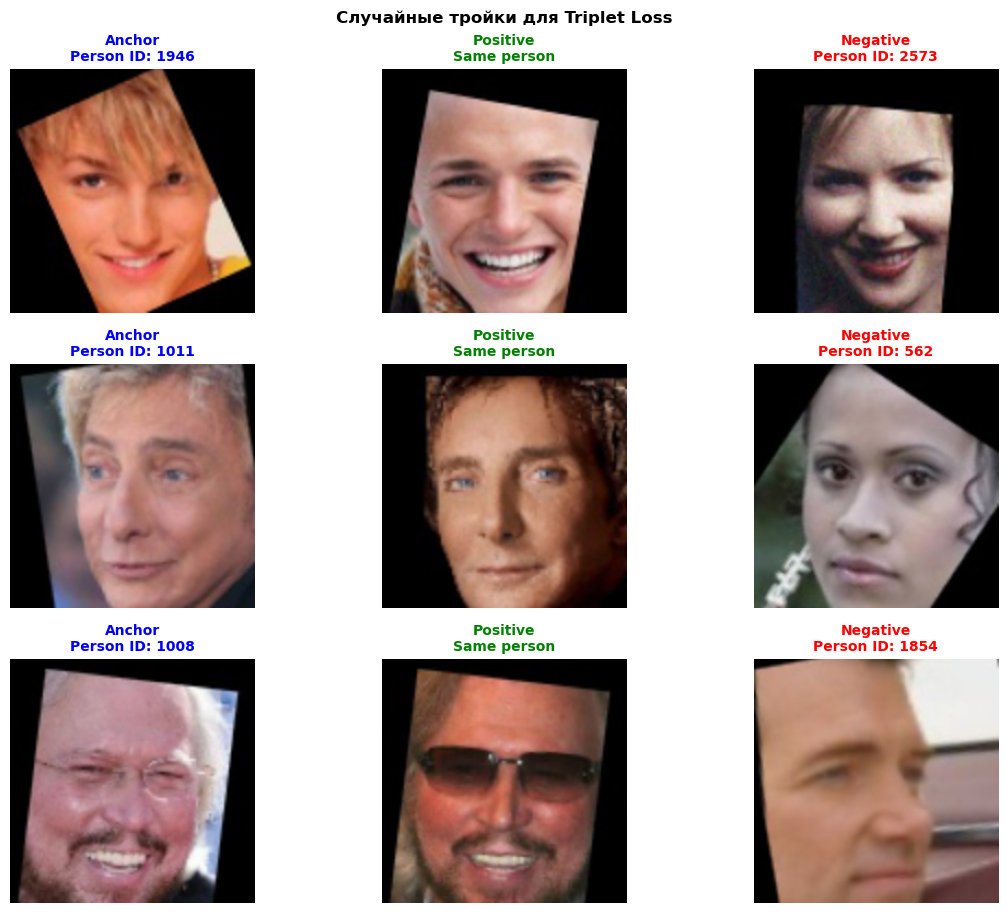

In [120]:
# визуализация троек изображений из датасета

def denormalize(tensor):
    """Денормализация изображения для визуализации"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().cpu().numpy().transpose(1, 2, 0)
    tensor = std * tensor + mean
    return np.clip(tensor, 0, 1)


# количество визуализаций
num_triplets = 3
# датасет для визуализации
vis_ds = train_dataset

# генерируем случайные индексы
indices = random.sample(range(len(vis_ds)), num_triplets)

plt.figure(figsize=(12, 3 * num_triplets))

for i, idx in enumerate(indices):
    anchor_img, positive_img, negative_img, anchor_id, negative_id = vis_ds[idx]
    
    # денормализуем изображения
    anchor_img = denormalize(anchor_img)
    positive_img = denormalize(positive_img)  
    negative_img = denormalize(negative_img)
    
    # Anchor изображение
    plt.subplot(num_triplets, 3, i*3 + 1)
    plt.imshow(anchor_img)
    plt.title(f'Anchor\nPerson ID: {anchor_id}', fontsize=10, fontweight='bold', color='blue')
    plt.axis('off')
    
    # Positive изображение (тот же человек)
    plt.subplot(num_triplets, 3, i*3 + 2)
    plt.imshow(positive_img)
    plt.title(f'Positive\nSame person', fontsize=10, fontweight='bold', color='green')
    plt.axis('off')
    
    # Negative изображение (другой человек)  
    plt.subplot(num_triplets, 3, i*3 + 3)
    plt.imshow(negative_img)
    plt.title(f'Negative\nPerson ID: {negative_id}', fontsize=10, fontweight='bold', color='red')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Случайные тройки для Triplet Loss', fontsize=12, fontweight='bold', y=1.01)
plt.show()


## Проверка готовности GPU

In [202]:
if DEVICE.type == 'cuda':
    gc.collect(); torch.cuda.empty_cache()
    pass

print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
print(f"Версия CUDA: {torch.version.cuda}")
print(f"Количество GPU: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Текущее устройство: {torch.cuda.current_device()}")
    print(f"Имя устройства: {torch.cuda.get_device_name(0)}")
    print(f"Память: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB свободно из {torch.cuda.mem_get_info()[1]/1024**3:.2f} GB")

    # Проверка простой операции на GPU
    try:
        test_tensor = torch.randn(100, 100).to(DEVICE)
        print("Тестовый тензор на GPU создан успешно")
    except Exception as e:
        print(f"Ошибка при создании тензора: {e}")

PyTorch версия: 2.5.1
CUDA доступна: True
Версия CUDA: 12.1
Количество GPU: 1
Текущее устройство: 0
Имя устройства: NVIDIA GeForce RTX 2060
Память: 1.30 GB свободно из 5.79 GB
Тестовый тензор на GPU создан успешно


## Обучение модели с Triple loss

In [ ]:
def train_triplet_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None,
                       device='cpu', start_epoch=0, num_epochs=20, checkpoint_dir='checkpoints',
                       history=None):
    """
    Обучение модели с Triplet Loss
    
    Args:
        model: модель для обучения
        train_loader: загрузчик трейновых данных
        val_loader: загрузчик валидационных данных  
        criterion: функция потерь (TripletLoss)
        optimizer: оптимизатор
        device: устройство для вычислений
        num_epochs: количество эпох для обучения
        checkpoint_dir: директория для сохранения чекпоинтов
        start_epoch: начальная эпоха (для продолжения обучения)
        history: словарь истории обучения или None
    Returns:
        history: история обучения
    """
    # папка для чекпоинтов
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    if history is None:
        history = {
            'train_losses': [],
            'val_accuracies': [],
            'val_pos_dists': [],
            'val_neg_dists': [],
            'best_val_acc': 0.0,
            'best_model_path': None
        }
    
    best_val_acc = history['best_val_acc']

    # сохраняем время начала обучения для добавления к имени чекпоинта
    time_start = time.strftime('%Y%m%d_%H%M')

    for epoch in range(start_epoch, start_epoch + num_epochs):
        # обучение
        model.train()
        train_loss = 0.0
        train_batches = 0        
        pbar = tqdm(train_loader, desc=f'[Train] Эпоха {epoch+1}/{start_epoch + num_epochs}', leave=True)
        for anchor_batch, pos_batch, neg_batch, _, _ in pbar:
            # перемещаем данные на устройство
            anchor_batch = anchor_batch.to(device)
            pos_batch = pos_batch.to(device)
            neg_batch = neg_batch.to(device)
            
            # обнуляем градиенты
            optimizer.zero_grad()
            
            # прямой проход - получаем эмбеддинги
            anchor_emb = model(anchor_batch)
            pos_emb = model(pos_batch)
            neg_emb = model(neg_batch)
            
            # лосс и шаг оптимизации
            loss = criterion(anchor_emb, pos_emb, neg_emb)
            loss.backward()
            optimizer.step()
            
            # суммируем метрики
            train_loss += loss.item()
            train_batches += 1
            
            pbar.set_postfix({'loss': f'{train_loss/train_batches:.4f}'})
        
        avg_train_loss = train_loss / train_batches if train_batches > 0 else 0.0
        history['train_losses'].append(avg_train_loss)
        
        # валидация
        model.eval()
        val_accuracy = 0.0
        val_pos_dist = 0.0
        val_neg_dist = 0.0
        val_batches = 0
        
        pbar = tqdm(val_loader, desc=f'[Validate] Эпоха {epoch+1}/{start_epoch + num_epochs}', leave=True)
        with torch.no_grad():
            for anchor_batch, pos_batch, neg_batch, _, _ in pbar:
                anchor_batch = anchor_batch.to(device)
                pos_batch = pos_batch.to(device)
                neg_batch = neg_batch.to(device)
                
                # получаем эмбеддинги
                anchor_emb, pos_emb, neg_emb = model.forward_triplet(anchor_batch, pos_batch, neg_batch)
                
                # вычисляем метрики
                accuracy, pos_dist, neg_dist = compute_triplet_accuracy(anchor_emb, pos_emb, neg_emb)
                
                # суммируем метрики
                val_accuracy += accuracy
                val_pos_dist += pos_dist
                val_neg_dist += neg_dist
                val_batches += 1

                
                pbar.set_postfix({
                    'acc': f'{val_accuracy/val_batches:.4f}',
                    'pos': f'{val_pos_dist/val_batches:.4f}', 
                    'neg': f'{val_neg_dist/val_batches:.4f}',
                    'Δ': f'{(val_neg_dist - val_pos_dist)/val_batches:.4f}'  # разница расстояний - чем больше, тем увереннее разделение кластеров
                })
        
        # усредняем метрики по всем батчам
        if val_batches > 0:
            val_accuracy /= val_batches
            val_pos_dist /= val_batches
            val_neg_dist /= val_batches
        
        history['val_accuracies'].append(val_accuracy)
        history['val_pos_dists'].append(val_pos_dist)
        history['val_neg_dists'].append(val_neg_dist)

        if scheduler:
            #scheduler.step(val_accuracy) # при использовании ReduceLROnPlateau
            scheduler.step() # если используется StepLR


        if val_accuracy > best_val_acc and val_accuracy > 0.7:
            # сохраняем лучшую модель
            best_val_acc = val_accuracy
            checkpoint_name = f'triplet_best_epoch_{time_start}_epoch_{epoch+1}_val_{val_accuracy:.4f}.pth'
            checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy,
                'train_loss': avg_train_loss,
            }, checkpoint_path)
            
            best_model_path = checkpoint_path
            history['best_model_path'] = best_model_path
            history['best_val_acc'] = best_val_acc
            
            print(f'Лучшая модель с точностью: {val_accuracy:.4f} сохранена в {checkpoint_path}')
        
    # сохраняем историю
    history_path = os.path.join(checkpoint_dir, f'training_history_{time_start}_epoch_{epoch+1}.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)
        
    return history



def test_triplet_model(model, test_loader, device='cpu'):
    """Тестирует модель на тестовом наборе данных"""
    model.eval()
    all_accuracies = []
    all_pos_dists = []
    all_neg_dists = []
    
    pbar = tqdm(test_loader, desc='Тестирование модели')
    
    with torch.no_grad():
        for anchor_batch, pos_batch, neg_batch, _, _ in pbar:
            anchor_batch = anchor_batch.to(device)
            pos_batch = pos_batch.to(device)
            neg_batch = neg_batch.to(device)
            
            # получаем эмбеддинги
            anchor_emb = model(anchor_batch)
            pos_emb = model(pos_batch)
            neg_emb = model(neg_batch)
            
            # вычисляем метрики
            accuracy, pos_dist, neg_dist = compute_triplet_accuracy(anchor_emb, pos_emb, neg_emb)
            
            all_accuracies.append(accuracy)
            all_pos_dists.append(pos_dist)
            all_neg_dists.append(neg_dist)
            
            # обновляем прогресс-бар
            avg_acc = sum(all_accuracies) / len(all_accuracies)
            pbar.set_postfix({'Test Acc': f'{avg_acc:.4f}'})
    
    # усредняем метрики по всему тестовому набору
    test_accuracy = sum(all_accuracies) / len(all_accuracies)
    test_pos_dist = sum(all_pos_dists) / len(all_pos_dists)
    test_neg_dist = sum(all_neg_dists) / len(all_neg_dists)
    
    return test_accuracy, test_pos_dist, test_neg_dist

In [ ]:
# создаем модель, критерий и оптимизатор
model = EmbeddingModel(embedding_size=EMBEDDING_SIZE).to(DEVICE)

criterion = TripletLoss(margin=0.3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) #, weight_decay=1e-4)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# инициализируем историю обучения здесь, чтобы можно было продолжить обучение
history_triple = {
        'train_losses': [],
        'val_accuracies': [],
        'val_pos_dists': [],
        'val_neg_dists': [],
        'best_val_acc': 0.0,
        'best_model_path': None
}


In [188]:
# обучение модели

num_epochs = 10

start_epoch = len(history_triple['train_losses'])


history_triple = train_triplet_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    start_epoch=start_epoch,
    num_epochs=num_epochs,
    checkpoint_dir=dir_checkpoints,
    history=history_triple
)

[Validate] Эпоха 12/20: 100%|██████████| 21/21 [00:16<00:00,  1.25it/s, acc=0.7967, pos=0.7840, neg=0.9996, Δ=0.2156]


Лучшая модель с точностью: 0.7967 сохранена в checkpoints/triplet_best_epoch_20260131_2225_epoch_12_val_0.7967.pth


[Validate] Эпоха 20/20: 100%|██████████| 21/21 [00:16<00:00,  1.28it/s, acc=0.7842, pos=0.7865, neg=1.0004, Δ=0.2139]


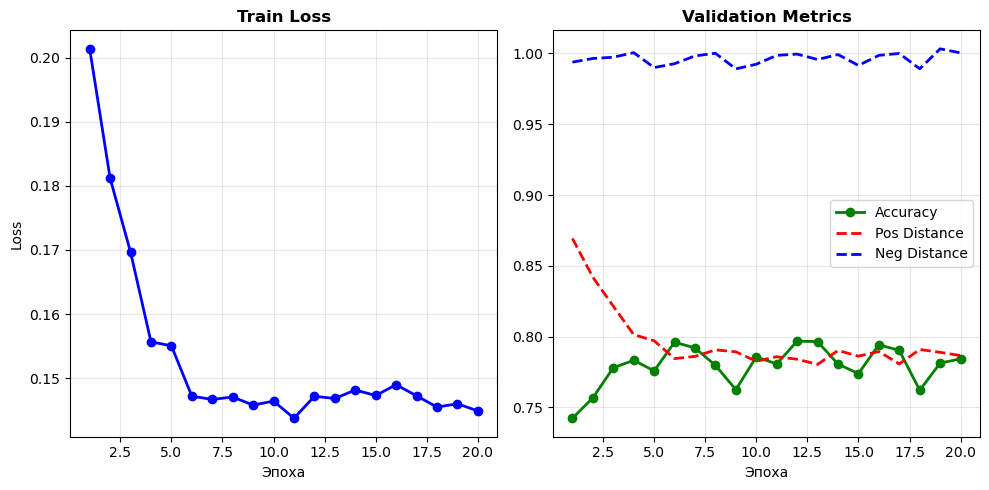

In [189]:
# визуализация результатов обучения
plt.figure(figsize=(10, 5))

epochs = range(1, len(history_triple['train_losses']) + 1)

# график потерь на трейне
plt.subplot(1, 2, 1)
plt.plot(epochs, history_triple['train_losses'], 'b-o', linewidth=2, markersize=6)
plt.title('Train Loss', fontsize=12, fontweight='bold')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# график точности на валидации
plt.subplot(1, 2, 2)
plt.plot(epochs, history_triple['val_accuracies'], 'g-o', linewidth=2, markersize=6, label='Accuracy')
plt.plot(epochs, history_triple['val_pos_dists'], 'r--', linewidth=2, label='Pos Distance')
plt.plot(epochs, history_triple['val_neg_dists'], 'b--', linewidth=2, label='Neg Distance')
plt.title('Validation Metrics', fontsize=12, fontweight='bold')
plt.xlabel('Эпоха')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'training_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [190]:
# загружаем лучшую модель
best_model_triple_path = history_triple['best_model_path']
best_model_triple = EmbeddingModel(embedding_size=EMBEDDING_SIZE).to(DEVICE) # создаем модель
checkpoint = torch.load(best_model_triple_path, map_location=DEVICE) # загружаем состояние модели
best_model_triple.load_state_dict(checkpoint['model_state_dict']) # загружаем веса модели
best_model_triple.eval()


# тестирование модели
test_accuracy, test_pos_dist, test_neg_dist = test_triplet_model(
    model=model,
    test_loader=test_loader,
    device=DEVICE
)

print(f"Точность (Accuracy): {test_accuracy:.4f}")
print(f"Среднее расстояние (anchor-positive): {test_pos_dist:.4f}")
print(f"Среднее расстояние (anchor-negative): {test_neg_dist:.4f}")
print(f"Разница расстояний: {test_neg_dist - test_pos_dist:.4f}")

/tmp/ipykernel_1240031/1771585828.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_triple_path, map_location=DEVICE) # загружаем состоя

Точность (Accuracy): 0.7823
Среднее расстояние (anchor-positive): 0.7861
Среднее расстояние (anchor-negative): 1.0004
Разница расстояний: 0.2143


In [191]:
# сохраним историю обучения модели в файл одноименный с лучшей моделью
base_name, _ = os.path.splitext(best_model_triple_path)
filename_history_triple = base_name + '.pkl'
with open(filename_history_triple, 'wb') as f:
    pickle.dump(history_triple, f)
print(f"История обучения модели сохранена в файл {filename_history_triple}")

История обучения модели сохранена в файл checkpoints/triplet_best_epoch_20260131_2225_epoch_12_val_0.7967.pkl


Общая accuracy модели: 0.8438 (54.0/64)
Показано правильных триплетов: 3
Показано неправильных триплетов: 3


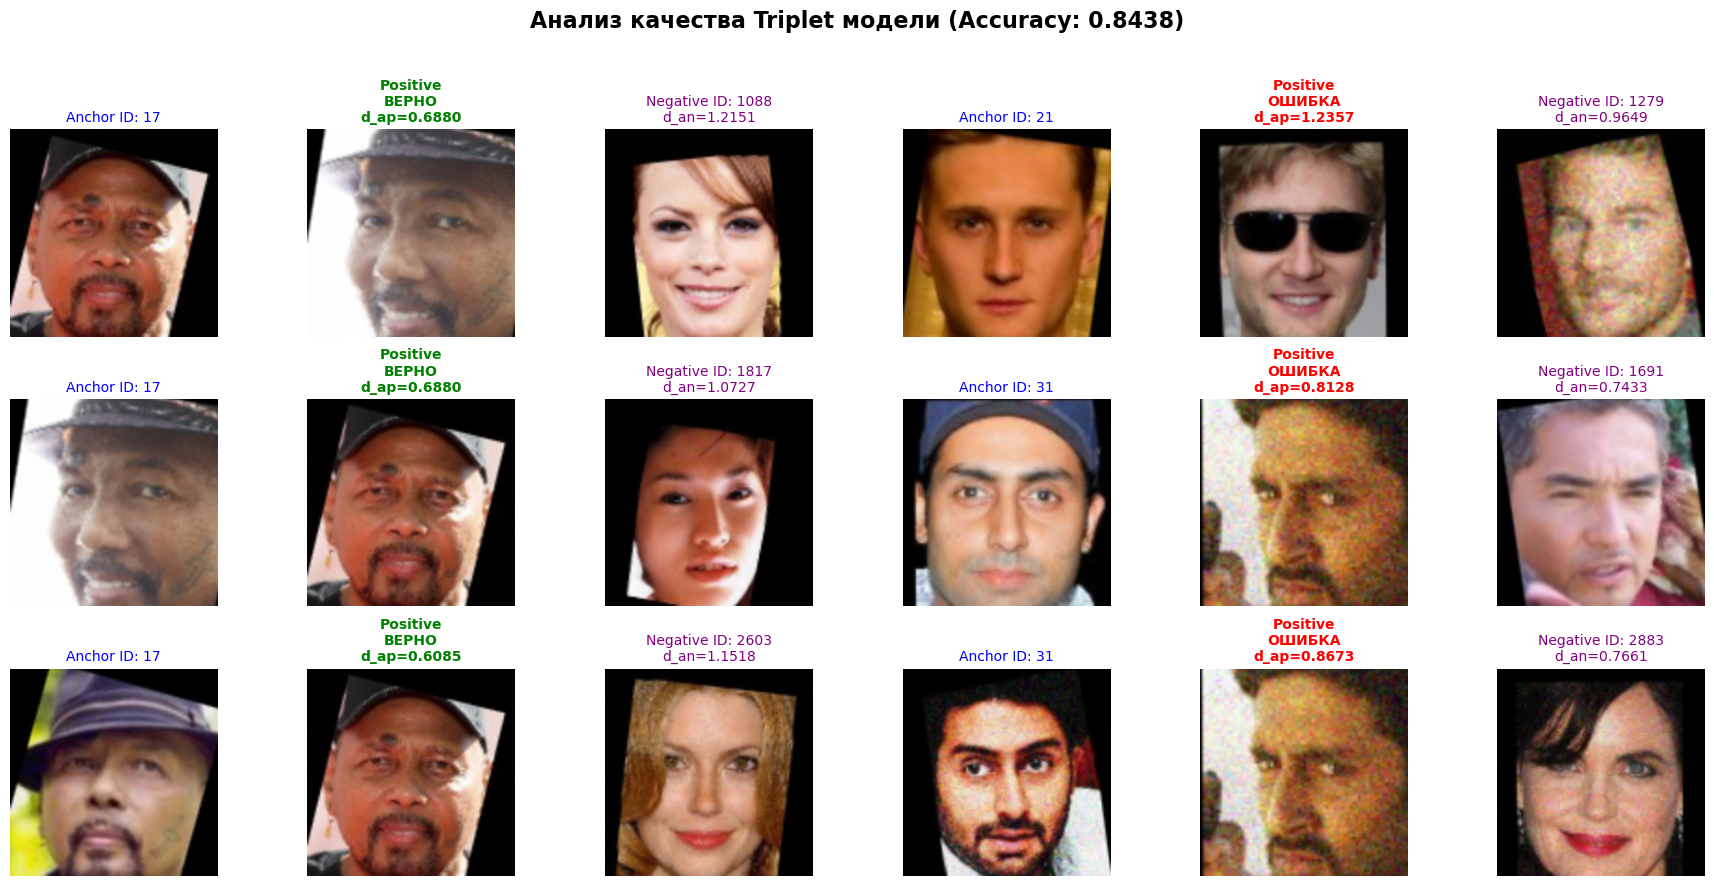

In [201]:
# визуализация качества распознавания

model = best_model_triple.to(DEVICE)
model.eval()

# Параметры визуализации
num_correct = 3  # Количество правильных триплетов для показа
num_wrong = 3    # Количество неправильных триплетов для показа

# Для денормализации
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

correct_triplets = []
wrong_triplets = []
total_correct = 0
total = 0

with torch.no_grad():
    for anchor_batch, pos_batch, neg_batch, anchor_ids, neg_ids in val_loader:
        anchor_batch = anchor_batch.to(DEVICE)
        pos_batch = pos_batch.to(DEVICE)
        neg_batch = neg_batch.to(DEVICE)
        
        # эмбеддинги
        anchor_emb, pos_emb, neg_emb = model.forward_triplet(anchor_batch, pos_batch, neg_batch)
        
        # нормализуем
        anchor_emb = F.normalize(anchor_emb, p=2, dim=1)
        pos_emb = F.normalize(pos_emb, p=2, dim=1)
        neg_emb = F.normalize(neg_emb, p=2, dim=1)
        
        # косинусное расстояние
        cos_ap = F.cosine_similarity(anchor_emb, pos_emb, dim=1)
        cos_an = F.cosine_similarity(anchor_emb, neg_emb, dim=1)
        d_ap = 1 - cos_ap
        d_an = 1 - cos_an
        
        # accuracy
        correct = (d_ap < d_an).float()
        total_correct += correct.sum().item()
        total += anchor_batch.size(0)
        
        # собираем триплеты для визуализации
        for i in range(anchor_batch.size(0)):
            if len(correct_triplets) < num_correct and correct[i].item():
                # денормализация
                anchor_img = anchor_batch[i].cpu().numpy().transpose(1, 2, 0)
                anchor_img = std * anchor_img + mean
                anchor_img = np.clip(anchor_img, 0, 1)
                
                pos_img = pos_batch[i].cpu().numpy().transpose(1, 2, 0)
                pos_img = std * pos_img + mean
                pos_img = np.clip(pos_img, 0, 1)
                
                neg_img = neg_batch[i].cpu().numpy().transpose(1, 2, 0)
                neg_img = std * neg_img + mean
                neg_img = np.clip(neg_img, 0, 1)
                
                correct_triplets.append({
                    'anchor': anchor_img,
                    'positive': pos_img, 
                    'negative': neg_img,
                    'anchor_id': anchor_ids[i].item(),
                    'neg_id': neg_ids[i].item(),
                    'd_ap': d_ap[i].item(),
                    'd_an': d_an[i].item()
                })
            
            if len(wrong_triplets) < num_wrong and not correct[i].item():
                anchor_img = anchor_batch[i].cpu().numpy().transpose(1, 2, 0)
                anchor_img = std * anchor_img + mean
                anchor_img = np.clip(anchor_img, 0, 1)
                
                pos_img = pos_batch[i].cpu().numpy().transpose(1, 2, 0)
                pos_img = std * pos_img + mean
                pos_img = np.clip(pos_img, 0, 1)
                
                neg_img = neg_batch[i].cpu().numpy().transpose(1, 2, 0)
                neg_img = std * neg_img + mean
                neg_img = np.clip(neg_img, 0, 1)
                
                wrong_triplets.append({
                    'anchor': anchor_img,
                    'positive': pos_img,
                    'negative': neg_img,
                    'anchor_id': anchor_ids[i].item(),
                    'neg_id': neg_ids[i].item(),
                    'd_ap': d_ap[i].item(),
                    'd_an': d_an[i].item()
                })
        
        if len(correct_triplets) >= num_correct and len(wrong_triplets) >= num_wrong:
            break

accuracy = total_correct / total if total > 0 else 0
print(f"Общая accuracy модели: {accuracy:.4f} ({total_correct}/{total})")
print(f"Показано правильных триплетов: {len(correct_triplets)}")
print(f"Показано неправильных триплетов: {len(wrong_triplets)}")


# визуализация
num_rows = max(num_correct, num_wrong)
fig, axes = plt.subplots(num_rows, 6, figsize=(18, num_rows * 3))
fig.suptitle(f'Анализ качества Triplet модели (Accuracy: {accuracy:.4f})', fontsize=16, fontweight='bold')

# Правильные триплеты
for i in range(num_correct):
    if i < len(correct_triplets):
        t = correct_triplets[i]
        
        # Anchor
        axes[i, 0].imshow(t['anchor'])
        axes[i, 0].set_title(f'Anchor ID: {t["anchor_id"]}', fontsize=10, color='blue')
        axes[i, 0].axis('off')
        
        # Positive
        axes[i, 1].imshow(t['positive'])
        axes[i, 1].set_title(f'Positive\nВЕРНО\nd_ap={t["d_ap"]:.4f}', 
                           fontsize=10, color='green', fontweight='bold')
        axes[i, 1].axis('off')
        
        # Negative
        axes[i, 2].imshow(t['negative'])
        axes[i, 2].set_title(f'Negative ID: {t["neg_id"]}\nd_an={t["d_an"]:.4f}', 
                           fontsize=10, color='purple')
        axes[i, 2].axis('off')
        
# Неправильные триплеты       
for i in range(num_wrong):
    if i < len(wrong_triplets):
        t = wrong_triplets[i]
        
        # Anchor
        axes[i, 3].imshow(t['anchor'])
        axes[i, 3].set_title(f'Anchor ID: {t["anchor_id"]}', fontsize=10, color='blue')
        axes[i, 3].axis('off')
        
        # Positive
        axes[i, 4].imshow(t['positive'])
        axes[i, 4].set_title(f'Positive\nОШИБКА\nd_ap={t["d_ap"]:.4f}', 
                           fontsize=10, color='red', fontweight='bold')
        axes[i, 4].axis('off')
        
        # Negative
        axes[i, 5].imshow(t['negative'])
        axes[i, 5].set_title(f'Negative ID: {t["neg_id"]}\nd_an={t["d_an"]:.4f}', 
                           fontsize=10, color='purple')
        axes[i, 5].axis('off')
        
# скрываем пустые subplot
for i in range(num_rows):
    for j in range(6):
        if (j < 3 and i >= len(correct_triplets)) or (j >= 3 and i >= len(wrong_triplets)):
            axes[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Оценка модели на Identification Rate Metric произведема в соответствующем ноутбуке (2_1_dop_Identification_Rate_Metric_oav.ipynb)

**Выводы. Модель EmbeddingModel, обученная с Triplet loss несмотря на высокий accuracy имеет очень посредственную Identification Rate метрику, т.е. наша модель плохо работает на незнакомых изображениях.**